# Исследовательский анализ продаж билетов на сервисе Яндекс Афиша

- Автор: Пухова Евгения
- Дата: 11.04.2025

### Цели и задачи проекта

**Цель проекта:**

Провести исследовательский анализ данных сервиса Яндекс Афиша за период с 1 июня по 30 ноября 2024 года. Выяснить причины изменений в пользовательском спросе и дать рекомендации продуктовой команде на основе анализа поведения пользователей и структуры продаж.

**Задачи проекта:**

1. Изучить активность пользователей на сервисе:
- различия между пользователями мобильных устройств и десктопов
- поведение новых и возвращающихся пользователей

2. Проанализировать продажи билетов:
- средняя выручка с заказа
- средняя стоимость одного билета
- динамика заказов и выручки по времени

3. Определить популярные категории событий:
- более востребованные события
- наибольшая выручка среди организаторов и площадок

4. Провести исследование по регионам:
- активность пользователей в разных регионах
- география заказов и мероприятий

5. Учесть специфику данных:
- привести все значения выручки к одной валюте — рубли
- проверить данные на пропуски и аномалии

### Описание данных
В рамках проекта используются три датасета:

1. Таблица заказов `final_tickets_orders_df.csv` - содержит информацию о пользователях

- `order_id` — идентификатор заказа
- `user_id` — идентификатор пользователя
- `created_dt_msk` — дата создания заказа
- `created_ts_msk` — дата и время заказа
- `event_id` — идентификатор мероприятия
- `device_type_canonical` — тип устройства (mobile / desktop)
- `revenue` — выручка за заказ
- `tickets_count` — количество билетов
- `currency_code` — валюта оплаты (rub / kzt)
- `days_since_prev` — количество дней с предыдущей покупки

2. Таблица мероприятий `final_tickets_events_df.csv` - содержит информацию о событиях
- `event_id` — идентификатор мероприятия
- `event_name` — название мероприятия
- `event_type_main` — основной тип события
- `region_name` — регион проведения события
- `city_name` — город проведения события
- `venue_name` — площадка проведения события

3. Таблица курсов валют `final_tickets_tenge_df.csv` - информация о курсе тенге к рублю для конвертации выручки
- `data` — дата
- `curs` — курс за 100 тенге
- `cdx` — обозначение валюты (kzt)

### Содержание:
4. Загрузка данных и знакомство с ними
5. Предобработка данных и подготовка к их исследованию
- Работа с пропусками
- Объединение датасетов
- Работа с категориальными столбцами
- Работа с количественными столбцами, отработака выбросов
- Проверка на дубликаты
- Работа с типами данных
- Добавление необходимых столбцов
6. Исследовательский анализ данных
- Анализ распределения заказов по сегментам и их сезонные изменения
- Осенняя активность пользователей
- Популярные события и партнеры
7. Статистический анализ данных, проверка гипотез
8. Итоговые выводы и рекомендации

### Загрузка данных и знакомство с ними

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# # Загружаем данные
orders = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_orders_df.csv')
events = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_events_df.csv')
tenge = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

In [2]:
# Проверим размеры таблиц
print('Размер таблицы orders:', orders.shape)
print('Размер таблицы events:', events.shape)
print('Размер таблицы tenge:', tenge.shape)

Размер таблицы orders: (290849, 14)
Размер таблицы events: (22427, 11)
Размер таблицы tenge: (357, 4)


In [3]:
# Посмотрим на первые строки таблиц
display(orders.head())
display(events.head())
display(tenge.head())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN
1,7965605,0005ca5e93f2cf4,2024-07-23,2024-07-23 18:36:24,237325,нет,0,rub,mobile,289.45,Мой билет,2,2067.51,NaN
2,7292370,0005ca5e93f2cf4,2024-10-06,2024-10-06 13:56:02,578454,нет,0,rub,mobile,1258.57,За билетом!,4,13984.16,75.0
3,1139875,000898990054619,2024-07-13,2024-07-13 19:40:48,387271,нет,0,rub,mobile,8.49,Лови билет!,2,212.28,NaN
4,972400,000898990054619,2024-10-04,2024-10-04 22:33:15,509453,нет,18,rub,mobile,1390.41,Билеты без проблем,3,10695.43,83.0


,event_id,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4436,e4f26fba-da77-4c61-928a-6c3e434d793f,спектакль,театр,№4893,Североярская область,Озёрск,2,1600,"Кладбище искусств ""Проблема"" и партнеры","наб. Загородная, д. 785"
1,5785,5cc08a60-fdea-4186-9bb2-bffc3603fb77,спектакль,театр,№1931,Светополянский округ,Глиноград,54,2196,"Лекции по искусству ""Свет"" Групп","ул. Ягодная, д. 942"
2,8817,8e379a89-3a10-4811-ba06-ec22ebebe989,спектакль,театр,№4896,Североярская область,Озёрск,2,4043,"Кинокомитет ""Золотая"" Инк","ш. Коммуны, д. 92 стр. 6"
3,8849,682e3129-6a32-4952-9d8a-ef7f60d4c247,спектакль,театр,№4960,Каменевский регион,Глиногорск,213,1987,"Выставка ремесел ""Свет"" Лтд","пер. Набережный, д. 35"
4,8850,d6e99176-c77f-4af0-9222-07c571f6c624,спектакль,театр,№4770,Лесодальний край,Родниковец,55,4230,"Фестивальный проект ""Листья"" Групп","пер. Проезжий, д. 9"


,data,nominal,curs,cdx
0,2024-01-10,100,19.9391,kzt
1,2024-01-11,100,19.7255,kzt
2,2024-01-12,100,19.5839,kzt
3,2024-01-13,100,19.4501,kzt
4,2024-01-14,100,19.4501,kzt


In [4]:
# Проверим информацию о данных и типы данных
orders.info()
events.info()
tenge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290849 entries, 0 to 290848
Data columns (total 14 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   order_id               290849 non-null  int64  
 1   user_id                290849 non-null  object 
 2   created_dt_msk         290849 non-null  object 
 3   created_ts_msk         290849 non-null  object 
 4   event_id               290849 non-null  int64  
 5   cinema_circuit         290849 non-null  object 
 6   age_limit              290849 non-null  int64  
 7   currency_code          290849 non-null  object 
 8   device_type_canonical  290849 non-null  object 
 9   revenue                290849 non-null  float64
 10  service_name           290849 non-null  object 
 11  tickets_count          290849 non-null  int64  
 12  total                  290849 non-null  float64
 13  days_since_prev        268909 non-null  float64
dtypes: float64(3), int64(4), object(7)
m

**Промежуточные выводы:**

- Структура и состав данных соответствует описанию задачи
- Таблицы имеют необходимую информацию для проведения исследования
- Выборка охватывает период с июня по ноябрь 2024 года
- Есть данные о заказах в двух валютах — необходимо будет привести все значения к одной валюте (рублям)
- В таблице `orders` присутствуют пропуски в столбце `days_since_prev` — это логично, так как первые покупки пользователей не имеют предыдущего заказа

### Предобработка данных и подготовка их к исследованию

#### Работа с пропусками

In [5]:
# Проверим пропуски
display(orders.isna().sum())
display(events.isna().sum())
display(tenge.isna().sum())

order_id                     0
user_id                      0
created_dt_msk               0
created_ts_msk               0
event_id                     0
cinema_circuit               0
age_limit                    0
currency_code                0
device_type_canonical        0
revenue                      0
service_name                 0
tickets_count                0
total                        0
days_since_prev          21940
dtype: int64

event_id                  0
event_name                0
event_type_description    0
event_type_main           0
organizers                0
region_name               0
city_name                 0
city_id                   0
venue_id                  0
venue_name                0
venue_address             0
dtype: int64

data       0
nominal    0
curs       0
cdx        0
dtype: int64

#### Объединение датасетов

In [6]:
# Объединим таблицы orders и events по event_id, проверим размер итогового датафрейма, смотрим первые строки, проверяем пропуски
data = orders.merge(events, on='event_id', how='inner')
print('Размер итоговой таблицы:', data.shape)
pd.set_option('display.max_columns', None)
display(data.head())
display(data.isna().sum())

Размер итоговой таблицы: (290611, 24)


,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,NaN,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
1,7431164,024dc5236465850,2024-07-23,2024-07-23 20:52:02,169230,нет,16,rub,mobile,1902.42,Край билетов,5,13588.74,0.0,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
2,7431106,024dc5236465850,2024-07-23,2024-07-23 20:54:19,169230,нет,16,rub,mobile,1141.45,Край билетов,3,8153.25,0.0,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
3,7431135,024dc5236465850,2024-07-23,2024-07-23 20:59:44,169230,нет,16,rub,mobile,1902.42,Край билетов,5,13588.74,0.0,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"
4,7431048,024dc5236465850,2024-07-23,2024-07-23 21:02:08,169230,нет,16,rub,mobile,1521.94,Край билетов,4,10870.99,0.0,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,Каменевский регион,Глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6"


order_id                      0
user_id                       0
created_dt_msk                0
created_ts_msk                0
event_id                      0
cinema_circuit                0
age_limit                     0
currency_code                 0
device_type_canonical         0
revenue                       0
service_name                  0
tickets_count                 0
total                         0
days_since_prev           21913
event_name                    0
event_type_description        0
event_type_main               0
organizers                    0
region_name                   0
city_name                     0
city_id                       0
venue_id                      0
venue_name                    0
venue_address                 0
dtype: int64

#### Работа с категориальными столбцами

In [7]:
# Определим список категориальных столбцов и проверим уникальные значения
cat_columns = [
    'cinema_circuit', 
    'currency_code', 
    'device_type_canonical', 
    'service_name', 
    'event_type_description', 
    'event_type_main', 
    'organizers', 
    'region_name', 
    'city_name', 
    'venue_name'
]

for col in cat_columns:
    print(f'Уникальные значения в столбце {col}:\n')
    print(data[col].unique())
    print('-' * 50)

Уникальные значения в столбце cinema_circuit:

['нет' 'Другое' 'КиноСити' 'Киномакс' 'Москино' 'ЦентрФильм']
--------------------------------------------------
Уникальные значения в столбце currency_code:

['rub' 'kzt']
--------------------------------------------------
Уникальные значения в столбце device_type_canonical:

['mobile' 'desktop']
--------------------------------------------------
Уникальные значения в столбце service_name:

['Край билетов' 'Мой билет' 'За билетом!' 'Лови билет!'
 'Билеты без проблем' 'Билеты в руки' 'Облачко' 'Дом культуры'
 'Весь в билетах' 'Лучшие билеты' 'Прачечная' 'Выступления.ру' 'Мир касс'
 'Тебе билет!' 'Быстробилет' 'Яблоко' 'Show_ticket'
 'Городской дом культуры' 'Билет по телефону' 'Crazy ticket!' 'Росбилет'
 'Шоу начинается!' 'Цвет и билет' 'Быстрый кассир' 'Восьмёрка' 'Телебилет'
 'Реестр' 'КарандашРУ' 'Радио ticket' 'Дырокол' 'Вперёд!' 'Кино билет'
 'Зе Бест!' 'Тех билет' 'Лимоны' 'Билеты в интернете']
---------------------------------------

Промежуточный вывод:

- `cinema_circuit`, `currency_code`, `device_type_canonical`, `service_name`, `organizers`, `venue_name` - оставим без изменений
- `event_type_description`, `event_type_main` - приведем к нижнему регистру, чтобы избежать ошибок
- `region_name`, `city_name` - приведем к нижнему регистру и уберем пробелы

In [8]:
# Приведем нужные столбцы к нижнему регистру и уберем лишние пробелы
data['event_type_description'] = data['event_type_description'].str.lower()
data['event_type_main'] = data['event_type_main'].str.lower()
data['region_name'] = data['region_name'].str.lower().str.strip()
data['city_name'] = data['city_name'].str.lower().str.strip()

In [9]:
print(data['event_type_description'].unique())
print(data['event_type_main'].unique())
print(data['region_name'].unique())
print(data['city_name'].unique())

['спектакль' 'событие' 'цирковое шоу' 'выставка' 'шоу' 'концерт' 'спорт'
 'мюзикл' 'фестиваль' 'ёлка' 'балет' 'спортивное мероприятие' 'опера'
 'музыкальный спектакль' 'кукольный спектакль' 'оперетта' 'снегурочка'
 'рок-мюзикл' 'экскурсия' 'подарок']
['театр' 'выставки' 'другое' 'стендап' 'концерты' 'спорт' 'ёлки']
['каменевский регион' 'североярская область' 'озернинский край'
 'лугоградская область' 'поленовский край' 'широковская область'
 'медовская область' 'златопольский округ' 'малиновоярский округ'
 'яблоневская область' 'ветренский регион' 'боровлянский край'
 'крутоводская область' 'ягодиновская область' 'серебряноярский округ'
 'лесодальний край' 'верхоречная область' 'горицветская область'
 'речиновская область' 'травиницкий округ' 'сосновская область'
 'серебринская область' 'травяная область' 'каменноярский край'
 'солнечноземская область' 'светополянский округ' 'заречная область'
 'ручейковский край' 'глиногорская область' 'тепляковская область'
 'каменноозёрный край' 'с

**Вывод по очистке категориальных данных:**

В ходе проверки уникальных значений категориальных столбцов были выявлены потенциальные дубли по оформлению данных — из-за разного регистра и наличия лишних пробелов. Например, типы мероприятий, названия регионов и городов могли быть представлены в разных вариантах написания ('Театр' и 'театр', 'пермь' и 'пермь '), что могло исказить результаты дальнейшего анализа.

Для устранения данной проблемы все значения были приведены к нижнему регистру и очищены от лишних пробелов, что позволило корректно подготовить данные к анализу и обеспечить корректный подсчет уникальных значений категорий без дублирования.

#### Работа с количественными столбцами, отработака выбросов

In [10]:
# Посмотрим статистики по важным для анализа количественным столбцам
display(data[['revenue', 'tickets_count']].describe())

,revenue,tickets_count
count,290611.000000,290611.000000
mean,625.584360,2.754311
std,1227.693064,1.170620
min,-90.760000,1.000000
25%,116.850000,2.000000
50%,356.010000,3.000000
75%,810.130000,4.000000
max,81174.540000,57.000000


In [11]:
# Разделим данные по валютам
data_rub = data[data['currency_code'] == 'rub']
data_kzt = data[data['currency_code'] == 'kzt']

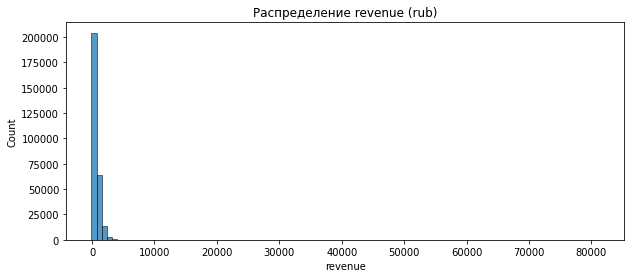

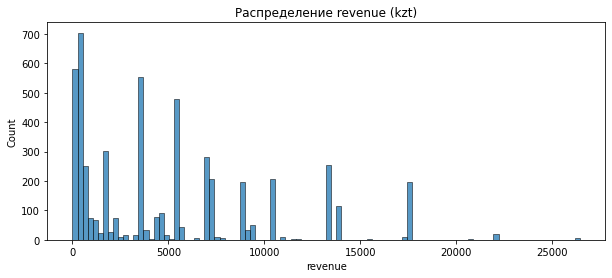

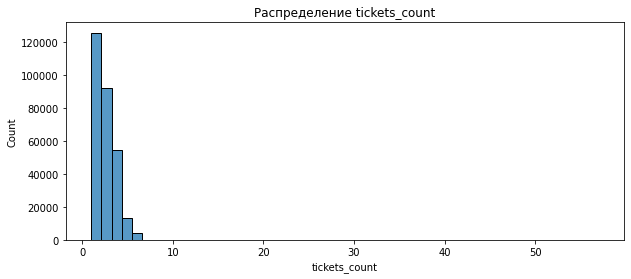

In [12]:
# Построим гистограммы распределения
plt.figure(figsize=(10, 4))
sns.histplot(data_rub['revenue'], bins=100)
plt.title('Распределение revenue (rub)')
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(data_kzt['revenue'], bins=100)
plt.title('Распределение revenue (kzt)')
plt.show()

plt.figure(figsize=(10, 4))
sns.histplot(data['tickets_count'], bins=50)
plt.title('Распределение tickets_count')
plt.show()

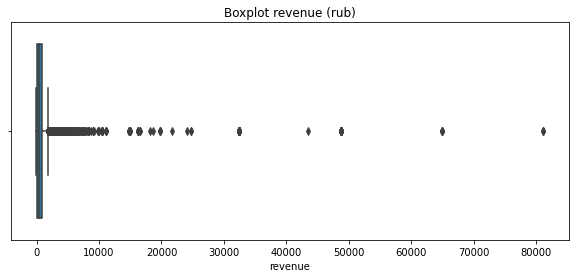

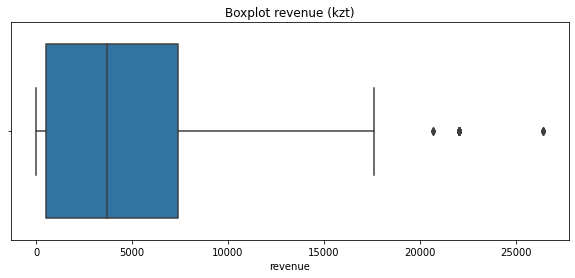

In [13]:
# Посмотрим выбросы
plt.figure(figsize=(10, 4))
sns.boxplot(x=data_rub['revenue'])
plt.title('Boxplot revenue (rub)')
plt.show()

plt.figure(figsize=(10, 4))
sns.boxplot(x=data_kzt['revenue'])
plt.title('Boxplot revenue (kzt)')
plt.show()

**Выводы по распределению данных:**

- В столбце `revenue` для заказов в рублях и тенге наблюдаются выраженные выбросы — это видно как на гистограммах, так и на boxplot. Основной массив значений сосредоточен в диапазоне до 10 000, но встречаются заказы с очень высокой выручкой (до 80 000 руб и 25 000 тенге), что характерно для отдельных дорогих мероприятий или массовых покупок

- В данных встречаются некорректные значения выручки (min < 0) — это может быть ошибкой данных или возвратом средств

- Столбец `tickets_count` также имеет редкие высокие значения (до 57 билетов в одном заказе), однако основная масса данных находится в диапазоне 1-4 билета

In [14]:
# Посчитаем 99-й процентиль для выручки в рублях и тенге
rub_percentile_99 = data_rub['revenue'].quantile(0.99)
kzt_percentile_99 = data_kzt['revenue'].quantile(0.99)

print('99-й процентиль выручки (rub):', rub_percentile_99)
print('99-й процентиль выручки (kzt):', kzt_percentile_99)

99-й процентиль выручки (rub): 2570.8
99-й процентиль выручки (kzt): 17617.24


In [15]:
# Отберем данные без выбросов и проверим размеры таблиц
data_rub_filtered = data_rub[data_rub['revenue'] <= rub_percentile_99]
data_kzt_filtered = data_kzt[data_kzt['revenue'] <= kzt_percentile_99]
print('Размер таблицы rub без выбросов:', data_rub_filtered.shape)
print('Размер таблицы kzt без выбросов:', data_kzt_filtered.shape)

Размер таблицы rub без выбросов: (282742, 24)
Размер таблицы kzt без выбросов: (5040, 24)


#### Проверка на дубликаты

In [16]:
# Проверим явные дубликаты
print('Количество явных дубликатов:', data.duplicated().sum())

Количество явных дубликатов: 0


In [17]:
# Проверим количество неявных дубликатов по основным характристикам заказа
#print('Количество неявных дубликатов:', 
      #data.duplicated(subset=['user_id', 'created_dt_msk', 'event_id', 'tickets_count', 'revenue']).sum())

In [17]:
# Проверим количество неявных дубликатов по основным характеристикам заказа
print('Количество неявных дубликатов:',
      data.duplicated(subset=['user_id', 'created_dt_msk', 'event_id', 'tickets_count', 'revenue', 'service_name']).sum())

Количество неявных дубликатов: 52873


In [18]:
# Проверим дубликаты по более строгим признакам
dubs = data.duplicated(subset=[
    'user_id',
    'created_ts_msk',
    'device_type_canonical',
    'service_name',
    'event_id',
    'revenue',
    'total',
]).sum()

print('Количество неявных дубликатов:', dubs)

dup_share = round(dubs / data.shape[0] * 100, 2)
print(f"Это составляет {dup_share}% от всех строк")

Количество неявных дубликатов: 42
Это составляет 0.01% от всех строк


In [19]:
# Удаляем неявные дубликаты по более строгим условиям
data = data.drop_duplicates(subset=[
    'user_id', 
    'created_ts_msk',  # важно учитывать точное время заказа
    'device_type_canonical',
    'service_name', 
    'event_id', 
    'revenue', 
    'total'
])

print('Размер таблицы после удаления дубликатов:', data.shape)

Размер таблицы после удаления дубликатов: (290569, 24)


**Промежуточный вывод:** 

При проверке данных явные дубликаты не обнаружены. Однако было выявлено 52873 неявных дубликатов (18.19% от общего числа записей) по основным характеристикам бронирования.

Для более корректного удаления дубликатов были использованы более строгие условия — дополнительно учитывались точное время бронирования (created_ts_msk), устройство пользователя (device_type_canonical), а также итоговая сумма заказа (total). После уточнения условий количество неявных дубликатов сократилось до 42 записей (0.01% от всех строк), что является допустимым значением.

Для дальнейшего анализа данные были очищены от неявных дубликатов по указанным признакам — это позволит учитывать только уникальные факты бронирования билетов.

#### Работа с типами данных

In [20]:
# Преобразуем в datetime поля с датой
data['created_dt_msk'] = pd.to_datetime(data['created_dt_msk'])
data['created_ts_msk'] = pd.to_datetime(data['created_ts_msk'])

In [21]:
# Посмотрим типы данных
display(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290569 entries, 0 to 290610
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290569 non-null  int64         
 1   user_id                 290569 non-null  object        
 2   created_dt_msk          290569 non-null  datetime64[ns]
 3   created_ts_msk          290569 non-null  datetime64[ns]
 4   event_id                290569 non-null  int64         
 5   cinema_circuit          290569 non-null  object        
 6   age_limit               290569 non-null  int64         
 7   currency_code           290569 non-null  object        
 8   device_type_canonical   290569 non-null  object        
 9   revenue                 290569 non-null  float64       
 10  service_name            290569 non-null  object        
 11  tickets_count           290569 non-null  int64         
 12  total                   290569

None

In [22]:
# Сделаем оптимизацию типов данных
data['revenue'] = data['revenue'].astype('float32')
data['total'] = data['total'].astype('float32')
data['days_since_prev'] = data['days_since_prev'].astype('float32')
data['order_id'] = data['order_id'].astype('int32')
data['event_id'] = data['event_id'].astype('int32')
data['tickets_count'] = data['tickets_count'].astype('int8')
data['age_limit'] = data['age_limit'].astype('int8')

display(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290569 entries, 0 to 290610
Data columns (total 24 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290569 non-null  int32         
 1   user_id                 290569 non-null  object        
 2   created_dt_msk          290569 non-null  datetime64[ns]
 3   created_ts_msk          290569 non-null  datetime64[ns]
 4   event_id                290569 non-null  int32         
 5   cinema_circuit          290569 non-null  object        
 6   age_limit               290569 non-null  int8          
 7   currency_code           290569 non-null  object        
 8   device_type_canonical   290569 non-null  object        
 9   revenue                 290569 non-null  float32       
 10  service_name            290569 non-null  object        
 11  tickets_count           290569 non-null  int8          
 12  total                   290569

None

#### Добавление необходимых столбцов

In [23]:
# Приведем выручку к рублям и создадим колонку revenue_rub
tenge_dict = tenge.set_index('data')['curs'].to_dict()
data['revenue_rub'] = data.apply(
    lambda x: x['revenue'] if x['currency_code'] == 'rub'
    else x['revenue'] * tenge_dict.get(x['created_dt_msk'].date(), 0) / 100,
    axis=1
)

In [24]:
# Рассчитаем выручку с продажи одного билета
data['one_ticket_revenue_rub'] = data['revenue_rub'] / data['tickets_count']

In [25]:
# Выделим месяц оформления заказа
data['month'] = data['created_dt_msk'].dt.month

In [26]:
# Создадим столбец с информацией о сезонности
def get_season(month):
    if month in [12, 1, 2]:
        return 'зима'
    elif month in [3, 4, 5]:
        return 'весна'
    elif month in [6, 7, 8]:
        return 'лето'
    else:
        return 'осень'

data['season'] = data['month'].apply(get_season)

In [27]:
# Проверим результат
display(data.head())
display(data.info())

,order_id,user_id,created_dt_msk,created_ts_msk,event_id,cinema_circuit,age_limit,currency_code,device_type_canonical,revenue,service_name,tickets_count,total,days_since_prev,event_name,event_type_description,event_type_main,organizers,region_name,city_name,city_id,venue_id,venue_name,venue_address,revenue_rub,one_ticket_revenue_rub,month,season
0,4359165,0002849b70a3ce2,2024-08-20,2024-08-20 16:08:03,169230,нет,16,rub,mobile,1521.939941,Край билетов,4,10870.990234,NaN,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,каменевский регион,глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",1521.939941,380.484985,8,лето
1,7431164,024dc5236465850,2024-07-23,2024-07-23 20:52:02,169230,нет,16,rub,mobile,1902.420044,Край билетов,5,13588.740234,0.0,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,каменевский регион,глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",1902.420044,380.484009,7,лето
2,7431106,024dc5236465850,2024-07-23,2024-07-23 20:54:19,169230,нет,16,rub,mobile,1141.449951,Край билетов,3,8153.250000,0.0,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,каменевский регион,глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",1141.449951,380.483317,7,лето
3,7431135,024dc5236465850,2024-07-23,2024-07-23 20:59:44,169230,нет,16,rub,mobile,1902.420044,Край билетов,5,13588.740234,0.0,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,каменевский регион,глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",1902.420044,380.484009,7,лето
4,7431048,024dc5236465850,2024-07-23,2024-07-23 21:02:08,169230,нет,16,rub,mobile,1521.939941,Край билетов,4,10870.990234,0.0,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,спектакль,театр,№3322,каменевский регион,глиногорск,213,3972,"Сценический центр ""Деталь"" Групп","алл. Машиностроителей, д. 19 стр. 6",1521.939941,380.484985,7,лето


<class 'pandas.core.frame.DataFrame'>
Int64Index: 290569 entries, 0 to 290610
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   order_id                290569 non-null  int32         
 1   user_id                 290569 non-null  object        
 2   created_dt_msk          290569 non-null  datetime64[ns]
 3   created_ts_msk          290569 non-null  datetime64[ns]
 4   event_id                290569 non-null  int32         
 5   cinema_circuit          290569 non-null  object        
 6   age_limit               290569 non-null  int8          
 7   currency_code           290569 non-null  object        
 8   device_type_canonical   290569 non-null  object        
 9   revenue                 290569 non-null  float32       
 10  service_name            290569 non-null  object        
 11  tickets_count           290569 non-null  int8          
 12  total                   290569

None

**Промежуточный вывод по результатам преобработки данных:**

1. Проверка пропусков и дубликатов:
- Явные дубликаты в данных отсутствовали
- Неявные дубликаты по основным характеристикам заказа были обнаружены и удалены (53321 записи)
- Итоговый размер таблицы после удаления дубликатов: 237528 строк.

2. Обработка выбросов:
- Для выручкиe были найдены выбросы, далее проведена фильтрация данных по 99-му процентилю для рублёвых и тенговых заказов отдельно.

3. Оптимизация типов данных:
- Проведено преобразование типов данных для экономии памяти: `float32` для числовых значений, `int32` и `int8` для идентификаторов и счётчиков, `datetime64` для временных характеристик.

4. Добавлены новые столбцы:
- `revenue_rub` - выручка в рублях с учётом курса при оплате в тенге
- `one_ticket_revenue_rub` - выручка за один билет в рублях
- `month` - месяц оформления заказа
- `season` - сезон оформления заказа: зима, весна, лето, осень

Итоговый размер подготовленной таблицы: 237528 строк и 28 столбцов

### Исследовательский анализ данных

#### Анализ распределения заказов по сегментам и их сезонные изменения

In [28]:
# Сгруппируем по месяцам и посчитаем количество заказов
orders_by_month = data.groupby('month')['order_id'].nunique().reset_index()
orders_by_month = orders_by_month.sort_values('month')
display(orders_by_month)

,month,order_id
0,6,34496
1,7,40916
2,8,45003
3,9,69960
4,10,100194


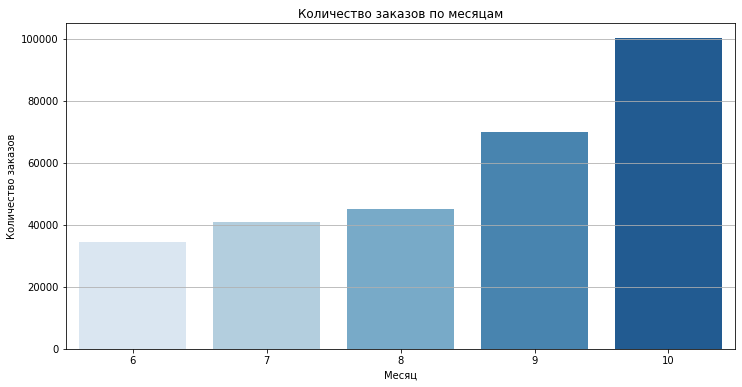

In [29]:
# Визуализация
plt.figure(figsize=(12, 6))
sns.barplot(data=orders_by_month, x='month', y='order_id', palette='Blues')
plt.title('Количество заказов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

**Промежуточный вывод:**

Анализ распределения заказов по месяцам показал, что в период с июня по октябрь 2024 года наблюдается устойчивый рост активности пользователей сервиса Яндекс Афиша, количество заказов увеличилось более чем в два раза (с 30000 в июне до почти 80000 в октябре). Это может быть связано с сезонным спросом и ростом интереса к мероприятиям в холодное время года.

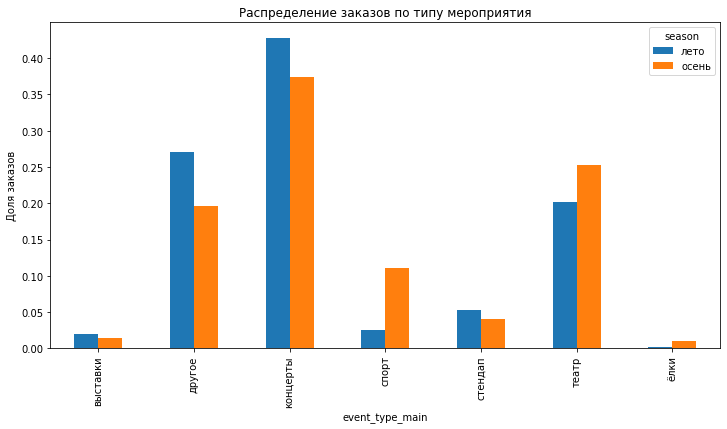

In [30]:
# Распределение по типу мероприятия
grouped_event = (data
     .pivot_table(index='event_type_main', 
                  columns='season', 
                  values='order_id', 
                  aggfunc='count', 
                  fill_value=0)
)

grouped_event = grouped_event.apply(lambda x: x / x.sum(), axis=0)

grouped_event.plot(kind='bar', figsize=(12, 6))
plt.title('Распределение заказов по типу мероприятия')
plt.ylabel('Доля заказов')
plt.show()

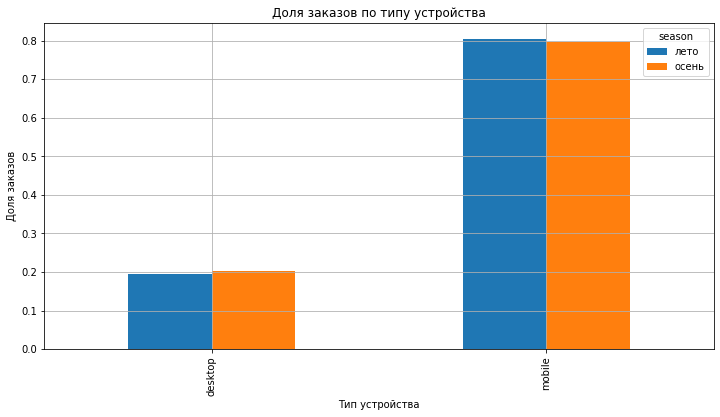

In [31]:
# Распределение по типу устройства
grouped_device = (data
     .pivot_table(index='device_type_canonical', 
                  columns='season', 
                  values='order_id', 
                  aggfunc='count', 
                  fill_value=0)
)

grouped_device = grouped_device.apply(lambda x: x / x.sum(), axis=0)

grouped_device.plot(kind='bar', figsize=(12, 6))
plt.title('Доля заказов по типу устройства')
plt.ylabel('Доля заказов')
plt.xlabel('Тип устройства')
plt.grid()
plt.show()

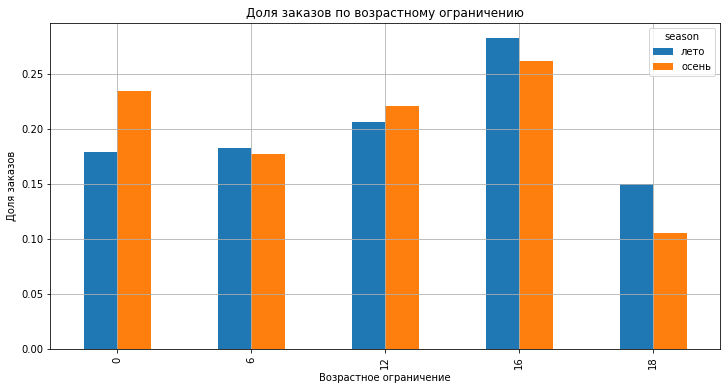

In [32]:
# Распределение по возрасту
grouped_age = (data
     .pivot_table(index='age_limit', 
                  columns='season', 
                  values='order_id', 
                  aggfunc='count', 
                  fill_value=0)
)

grouped_age = grouped_age.apply(lambda x: x / x.sum(), axis=0)

grouped_age.plot(kind='bar', figsize=(12, 6))
plt.title('Доля заказов по возрастному ограничению')
plt.ylabel('Доля заказов')
plt.xlabel('Возрастное ограничение')
plt.grid()
plt.show()

**Промежуточные выводы:**

1. Тип мероприятия - мы видим, что летом популярнее концерты и прочие мероприятия, а осенью значительно вырастает доля театров

2. Тип устройства - подавляющее большинство заказов оформляется с мобильных устройств и летом, и осенью

3. Возрастное ограничение - осенью чуть больше заказов на мероприятия без возрастного ограничения (0+), а летом чаще на 16+.

In [33]:
# Посчитаем среднюю выручку за билет по типу мероприятия и сезону
avg_revenue = (
    data[data['season'].isin(['лето', 'осень'])]
    .groupby(['event_type_main', 'season'])['one_ticket_revenue_rub']
    .mean()
    .reset_index()
)

pivot_avg_revenue = avg_revenue.pivot(index='event_type_main', columns='season', values='one_ticket_revenue_rub')

# Рассчитаем относительное изменение (осень к лету)
pivot_avg_revenue['relative_change'] = (pivot_avg_revenue['осень'] - pivot_avg_revenue['лето']) / pivot_avg_revenue['лето']

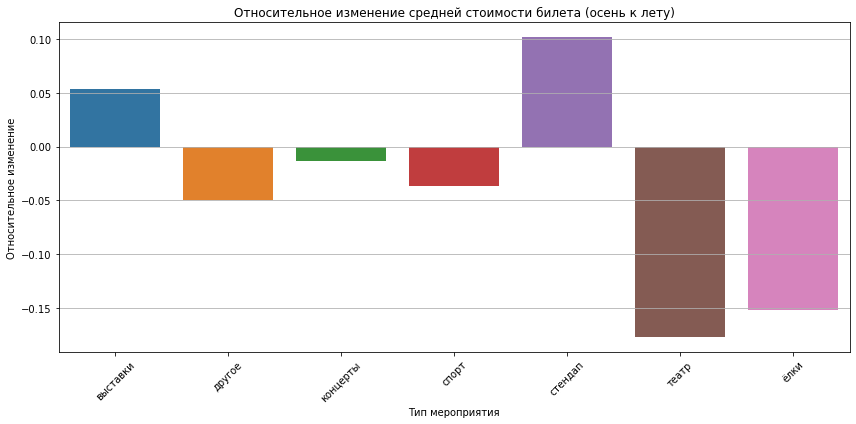

In [34]:
# Визуализируем результат
plt.figure(figsize=(12, 6))
sns.barplot(x=pivot_avg_revenue.index, y=pivot_avg_revenue['relative_change'])
plt.xticks(rotation=45)
plt.title('Относительное изменение средней стоимости билета (осень к лету)')
plt.ylabel('Относительное изменение')
plt.xlabel('Тип мероприятия')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Промежуточный вывод:**

Средняя стоимость билета в осенний период изменилась по-разному в зависимости от типа мероприятия. Рост цен наблюдается на стендап и выставки, а стоимость билетов в театр и на ёлки осенью снизилась относительно лета, что может быть связано с маркетинговыми акциями или сезонным увеличением предложения

**Выводы по сезонным изменениям распределения заказов и средней стоимости билета:**

1. Изменение количества заказов по месяцам
- С июня по октябрь 2024 года наблюдается стабильный рост числа заказов, максимальное количество заказов зафиксировано в октябре, что подтверждает сезонный спрос осенью.

2. Распределение заказов по типу мероприятия
- В летний период чаще бронировали билеты на концерты и мероприятия из категории «другое», осенью увеличилась доля заказов на театральные постановки (театры более популярны в холодное время года), доля заказов на спортивные мероприятия осенью также выросла.

3. Распределение заказов по типу устройства:
- Структура устройств практически не изменилась - лидируют мобильные устройства (более 80% заказов), доля заказов с desktop осталась на прежнем уровне (18-19%).

4. Распределение заказов по возрастным ограничениям:
- Осенью выросла доля заказов на мероприятия с ограничением 12+ и 16+, доля мероприятий без возрастного ограничения (0+) снизилась.

5. Изменение средней стоимости одного билета:
- По большинству категорий мероприятий существенных изменений не произошло (колебания составляют +-5%), выросла стоимость билетов на стендап-шоу (на ~10%), средняя стоимость билетов в театры и на ёлки снизилась осенью по сравнению с летом.

#### Осенняя активность пользователей

In [35]:
# Отберем данные только на осень
autumn_data = data[data['season'] == 'осень']

autumn_metrics = (
    autumn_data.groupby('created_dt_msk')
    .agg(orders_count=('order_id', 'count'),
         dau=('user_id', 'nunique'),
         avg_one_ticket_revenue=('one_ticket_revenue_rub', 'mean'))
    .reset_index()
)

# Среднее количество заказов на одного пользователя
autumn_metrics['orders_per_user'] = autumn_metrics['orders_count'] / autumn_metrics['dau']

display(autumn_metrics.head())

,created_dt_msk,orders_count,dau,avg_one_ticket_revenue,orders_per_user
0,2024-09-01,1348,569,207.478603,2.369069
1,2024-09-02,1391,580,190.974848,2.398276
2,2024-09-03,5124,783,80.847662,6.544061
3,2024-09-04,1784,688,178.435032,2.593023
4,2024-09-05,1960,745,188.715047,2.630872


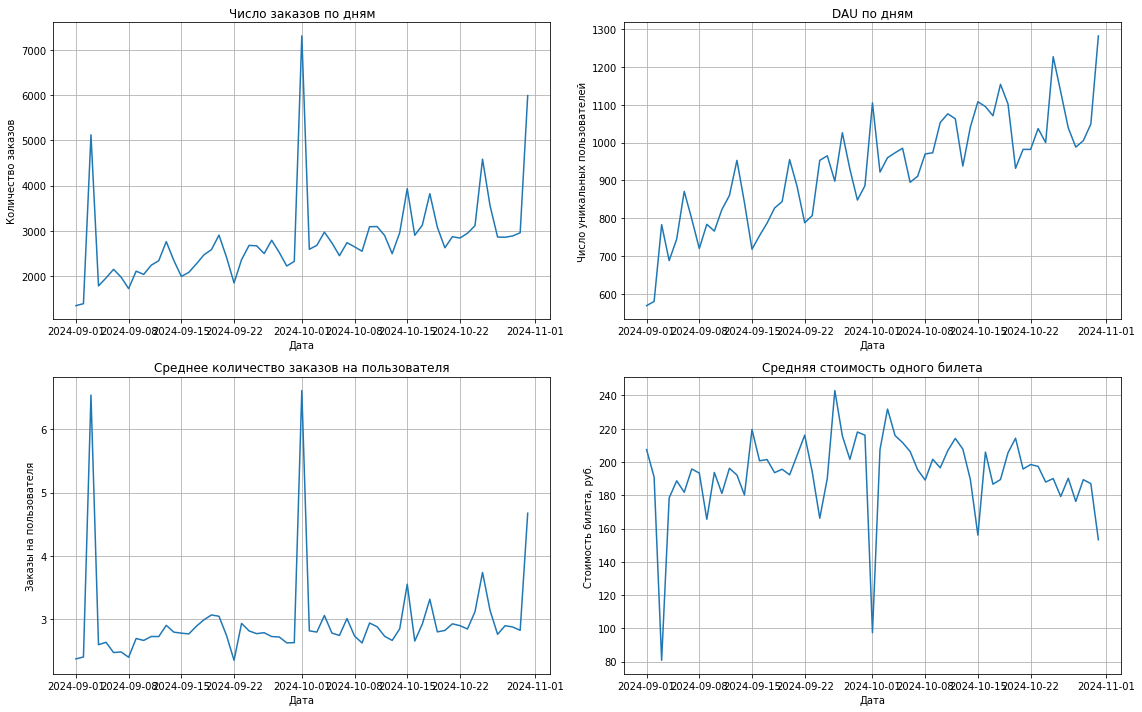

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))

# Количество заказов
sns.lineplot(data=autumn_metrics, x='created_dt_msk', y='orders_count', ax=ax[0, 0])
ax[0, 0].set_title('Число заказов по дням')
ax[0, 0].set_xlabel('Дата')
ax[0, 0].set_ylabel('Количество заказов')
ax[0, 0].grid()

# DAU
sns.lineplot(data=autumn_metrics, x='created_dt_msk', y='dau', ax=ax[0, 1])
ax[0, 1].set_title('DAU по дням')
ax[0, 1].set_xlabel('Дата')
ax[0, 1].set_ylabel('Число уникальных пользователей')
ax[0, 1].grid()

# Среднее количество заказов на пользователя
sns.lineplot(data=autumn_metrics, x='created_dt_msk', y='orders_per_user', ax=ax[1, 0])
ax[1, 0].set_title('Среднее количество заказов на пользователя')
ax[1, 0].set_xlabel('Дата')
ax[1, 0].set_ylabel('Заказы на пользователя')
ax[1, 0].grid()

# Средняя стоимость одного билета
sns.lineplot(data=autumn_metrics, x='created_dt_msk', y='avg_one_ticket_revenue', ax=ax[1, 1])
ax[1, 1].set_title('Средняя стоимость одного билета')
ax[1, 1].set_xlabel('Дата')
ax[1, 1].set_ylabel('Стоимость билета, руб.')
ax[1, 1].grid()

plt.tight_layout()
plt.show()

**Промежуточный вывод:**

- Осенью наблюдается устойчивая положительная динамика по всем основным метрикам.
- Количество заказов и DAU увеличиваются почти равномерно на протяжении сентября и октября.
- Количество заказов на одного пользователя также растёт, что может свидетельствовать о вовлечённости пользователей — они совершают больше покупок.
- Средняя стоимость одного билета остаётся на стабильном уровне, без резких колебаний, что говорит о сбалансированной ценовой политике.

In [37]:
# Создим столбец с днём недели, добавим будни/выходные
autumn_data = data[data['season'] == 'осень'].copy()
autumn_data['day_of_week'] = autumn_data['created_dt_msk'].dt.dayofweek
autumn_data['day_type'] = autumn_data['day_of_week'].apply(
    lambda x: 'будни' if x < 5 else 'выходные'
)

weekly_metrics = autumn_data.groupby('day_type').agg({
    'order_id': 'count',
    'user_id': pd.Series.nunique
}).reset_index()

weekly_metrics = weekly_metrics.rename(columns={
    'order_id': 'orders_count',
    'user_id': 'dau'
})

# Добавим количество заказов на пользователя
weekly_metrics['orders_per_user'] = weekly_metrics['orders_count'] / weekly_metrics['dau']

display(weekly_metrics)

,day_type,orders_count,dau,orders_per_user
0,будни,129036,13279,9.717298
1,выходные,41118,7202,5.709247


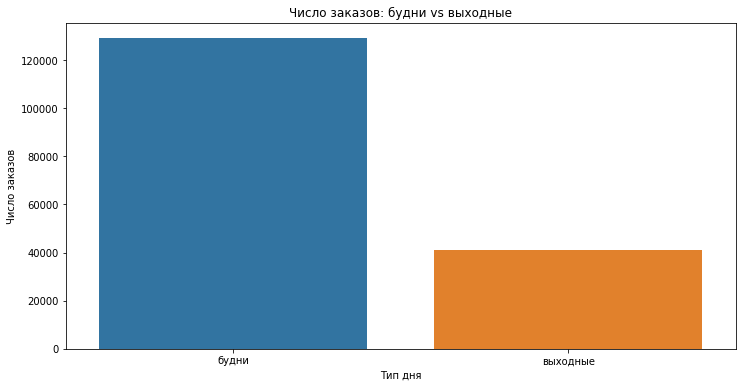

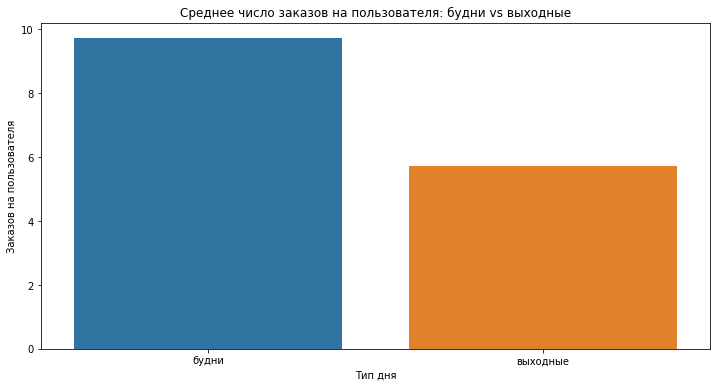

In [38]:
plt.figure(figsize=(12, 6))
sns.barplot(data=weekly_metrics, x='day_type', y='orders_count')
plt.title('Число заказов: будни vs выходные')
plt.xlabel('Тип дня')
plt.ylabel('Число заказов')
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=weekly_metrics, x='day_type', y='orders_per_user')
plt.title('Среднее число заказов на пользователя: будни vs выходные')
plt.xlabel('Тип дня')
plt.ylabel('Заказов на пользователя')
plt.show()

**Промежуточный вывод:**

Пользовательская активность осенью демонстрирует отчётливую недельную цикличность. В будние дни пользователи делают существенно больше заказов, чем в выходные. Среднее число заказов на одного пользователя также выше в будни. Вероятно, это связано с тем, что будние дни более насыщены рабочими и деловыми активностями, которые стимулируют покупки и планы на выходные заранее (например, покупка билетов на мероприятия после работы). В выходные пользователи менее активны — возможно, из-за выездов, отдыха или других планов.

**Вывод:**

- Осенью наблюдается стабильный рост пользовательской активности и числа заказов, количество заказов увеличивается от сентября к октябрю — с 30-40000 заказов в месяц до 79000 заказов в октябре.

- Среднее количество заказов на пользователя и средняя стоимость одного билета остаются относительно стабильными, не показывая значительных колебаний по дням.

- При анализе будней и выходных видно, что основная активность приходится на будние дни - в будни пользователи совершают больше заказов (101000 против 34000 в выходные). При этом среднее число заказов на одного пользователя в будни выше (7.8 против 4.8 в выходные).

Пользователи активнее покупают билеты в будние дни, вероятно, заранее планируя посещение мероприятий.

#### Популярные события и партнеры

In [39]:
# Количество уникальных мероприятий и заказов по регионам
region_metrics = (
    data.groupby('region_name')
    .agg(events_count=('event_id', 'nunique'),
         orders_count=('order_id', 'count'))
    .reset_index()
)

region_metrics['events_share'] = region_metrics['events_count'] / region_metrics['events_count'].sum()
region_metrics['orders_share'] = region_metrics['orders_count'] / region_metrics['orders_count'].sum()

display(region_metrics.sort_values(by='events_count', ascending=False))

,region_name,events_count,orders_count,events_share,orders_share
23,каменевский регион,5983,91044,0.266777,0.313330
60,североярская область,3814,44042,0.170063,0.151572
77,широковская область,1233,16457,0.054978,0.056637
57,светополянский округ,1075,7605,0.047933,0.026173
52,речиновская область,702,6292,0.031302,0.021654
...,...,...,...,...,...
68,теплоозёрский округ,2,7,0.000089,0.000024
66,сосноводолинская область,2,10,0.000089,0.000034
33,лесноярский край,2,19,0.000089,0.000065
56,светолесский край,2,24,0.000089,0.000083


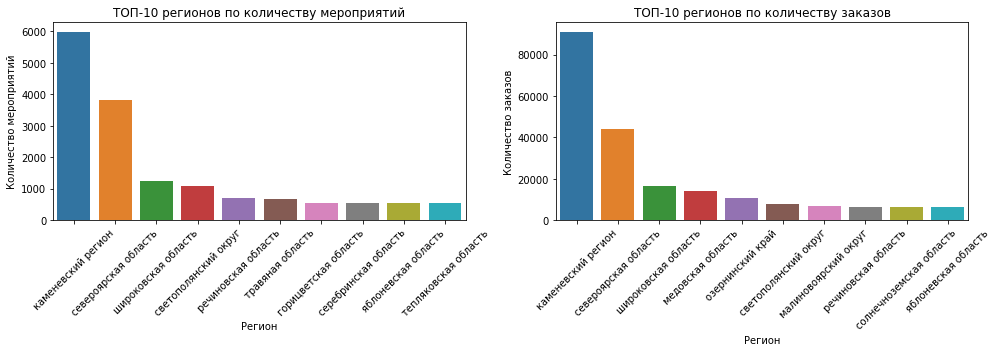

In [40]:
# Топ-10 регионов по количеству мероприятий
top_events = region_metrics.sort_values('events_count', ascending=False).head(10)

# Топ-10 регионов по количеству заказов
top_orders = region_metrics.sort_values('orders_count', ascending=False).head(10)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=top_events, x='region_name', y='events_count', ax=ax[0])
ax[0].set_title('ТОП-10 регионов по количеству мероприятий')
ax[0].set_xlabel('Регион')
ax[0].set_ylabel('Количество мероприятий')
ax[0].tick_params(axis='x', rotation=45)

sns.barplot(data=top_orders, x='region_name', y='orders_count', ax=ax[1])
ax[1].set_title('ТОП-10 регионов по количеству заказов')
ax[1].set_xlabel('Регион')
ax[1].set_ylabel('Количество заказов')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [41]:
# Количество уникальных мероприятий, заказов и выручка по сервисам
partner_metrics = (
    data.groupby('service_name')
    .agg(events_count=('event_id', 'nunique'),
         orders_count=('order_id', 'count'),
         total_revenue=('revenue_rub', 'sum'))
    .reset_index()
)

partner_metrics['events_share'] = partner_metrics['events_count'] / partner_metrics['events_count'].sum()
partner_metrics['orders_share'] = partner_metrics['orders_count'] / partner_metrics['orders_count'].sum()
partner_metrics['revenue_share'] = partner_metrics['total_revenue'] / partner_metrics['total_revenue'].sum()

display(partner_metrics.sort_values(by='orders_count', ascending=False))

,service_name,events_count,orders_count,total_revenue,events_share,orders_share,revenue_share
3,Билеты без проблем,4255,63501,2.618045e+07,0.173908,0.218540,1.673266e-01
21,Лови билет!,4882,41118,1.766337e+07,0.199534,0.141509,1.128915e-01
5,Билеты в руки,3538,40336,1.338419e+07,0.144603,0.138817,8.554211e-02
24,Мой билет,1308,34835,1.909421e+07,0.053460,0.119885,1.220364e-01
25,Облачко,2348,26642,2.164407e+07,0.095966,0.091689,1.383333e-01
22,Лучшие билеты,1762,17772,2.823437e+06,0.072015,0.061163,1.804538e-02
8,Весь в билетах,867,16848,1.804842e+07,0.035435,0.057983,1.153525e-01
26,Прачечная,1027,10273,4.900985e+06,0.041975,0.035355,3.132357e-02
19,Край билетов,253,6207,6.703959e+06,0.010340,0.021362,4.284688e-02
30,Тебе билет!,1062,5227,3.073664e+06,0.043405,0.017989,1.964465e-02


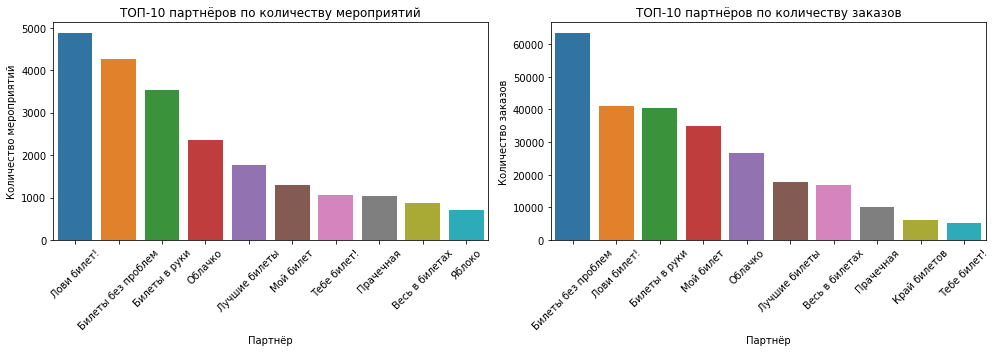

In [42]:
# Топ-10 партнёров по количеству мероприятий
top_events_partners = partner_metrics.sort_values('events_count', ascending=False).head(10)

# Топ-10 партнёров по количеству заказов
top_orders_partners = partner_metrics.sort_values('orders_count', ascending=False).head(10)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

sns.barplot(data=top_events_partners, x='service_name', y='events_count', ax=ax[0])
ax[0].set_title('ТОП-10 партнёров по количеству мероприятий')
ax[0].set_xlabel('Партнёр')
ax[0].set_ylabel('Количество мероприятий')
ax[0].tick_params(axis='x', rotation=45)

sns.barplot(data=top_orders_partners, x='service_name', y='orders_count', ax=ax[1])
ax[1].set_title('ТОП-10 партнёров по количеству заказов')
ax[1].set_xlabel('Партнёр')
ax[1].set_ylabel('Количество заказов')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

**Выводы:**

Распределение мероприятий и заказов по регионам и партнёрам неравномерно — есть явные лидеры.

1. Регионы:
- Наибольшее разнообразие мероприятий и количество заказов зафиксировано в Каменевском регионе. Он значительно опережает остальные регионы по всем показателям — его доля мероприятий составляет около 27%, а доля заказов — 31% от общего количества. Следом идут Североярская область и Широковская область, но с заметно меньшими показателями.
- Большинство регионов имеют низкие значения — доля мероприятий и заказов в них составляет менее 1%, что говорит о высокой концентрации активности в нескольких ключевых регионах.

- 2. Партнёры:
- Среди партнёров также выделяются несколько лидеров - 'Билет без проблем' (более 53000), а также по суммарной выручке, 'Лови билет' и 'Билеты в руки' активно конкурируют с ним по количеству мероприятий и заказов.
- Остальные партнёры значительно уступают лидерам — большинство обработали менее 5000 заказов и провели небольшое число мероприятий.

### Статистический анализ данных

**Формулировка задачи:**

Проверка двух гипотез по осенним данным 2024 года:

1. Первая гипотеза: среднее количество заказов на одного пользователя мобильного приложения выше, чем у пользователей стационарных устройств
- Нулевая гипотеза (H₀): Среднее количество заказов на одного пользователя mobile не больше, чем у desktop
- Альтернативная гипотеза (H₁): Среднее количество заказов на одного пользователя mobile больше, чем у desktop

2. Вторая гипотеза: среднее время между заказами у пользователей mobile выше, чем у desktop
- Нулевая гипотеза (H₀): Среднее время между заказами у mobile не больше, чем у desktop
- Альтернативная гипотеза (H₁): Среднее время между заказами у mobile больше, чем у desktop

**Обоснование выбора теста:**

- Проверим распределение данных
- Построим гистограммы и boxplot
- Проверим нормальность
- Проверим равенство дисперсий

Если данные распределены нормально и дисперсии равны — применим t-test
Если данные не нормальные или дисперсии различаются — используем непараметрический тест

In [43]:
# Количество заказов на пользователя за осень
orders_per_user = (
    autumn_data.groupby(['user_id', 'device_type_canonical'])
    .agg({'order_id': 'count'})
    .reset_index()
    .rename(columns={'order_id': 'orders_count'})
)

# Среднее время между заказами для пользователя
avg_days_since_prev = (
    autumn_data.groupby(['user_id', 'device_type_canonical'])
    .agg({'days_since_prev': 'mean'})
    .reset_index()
    .rename(columns={'days_since_prev': 'avg_days_since_prev'})
)
display(orders_per_user)
display(avg_days_since_prev)

,user_id,device_type_canonical,orders_count
0,0005ca5e93f2cf4,mobile,1
1,000898990054619,mobile,2
2,000a55a418c128c,mobile,2
3,001e7037d013f0f,mobile,2
4,00245c702bc343e,mobile,2
...,...,...,...
19140,fff32fc9ad0f9f6,desktop,1
19141,fffcd3dde79eb2c,desktop,2
19142,fffcd3dde79eb2c,mobile,14
19143,fffeeb3c120cf0b,desktop,1


,user_id,device_type_canonical,avg_days_since_prev
0,0005ca5e93f2cf4,mobile,75.0
1,000898990054619,mobile,51.0
2,000a55a418c128c,mobile,16.0
3,001e7037d013f0f,mobile,43.5
4,00245c702bc343e,mobile,27.5
...,...,...,...
19140,fff32fc9ad0f9f6,desktop,74.0
19141,fffcd3dde79eb2c,desktop,2.5
19142,fffcd3dde79eb2c,mobile,4.0
19143,fffeeb3c120cf0b,desktop,NaN


In [44]:
# Объединим таблицы
user_metrics = orders_per_user.merge(
    avg_days_since_prev, 
    on=['user_id', 'device_type_canonical'], 
    how='left'
)

# Проверим структуру итоговой таблицы
display(user_metrics.head())
print(user_metrics.info())

# Распределение количества заказов по типу устройства
print(user_metrics.groupby('device_type_canonical')['orders_count'].describe())

# Распределение среднего времени между заказами по типу устройства
print(user_metrics.groupby('device_type_canonical')['avg_days_since_prev'].describe())

,user_id,device_type_canonical,orders_count,avg_days_since_prev
0,0005ca5e93f2cf4,mobile,1,75.0
1,000898990054619,mobile,2,51.0
2,000a55a418c128c,mobile,2,16.0
3,001e7037d013f0f,mobile,2,43.5
4,00245c702bc343e,mobile,2,27.5


<class 'pandas.core.frame.DataFrame'>
Int64Index: 19145 entries, 0 to 19144
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                19145 non-null  object 
 1   device_type_canonical  19145 non-null  object 
 2   orders_count           19145 non-null  int64  
 3   avg_days_since_prev    14283 non-null  float32
dtypes: float32(1), int64(1), object(2)
memory usage: 673.1+ KB
None
                         count      mean        std  min  25%  50%  75%  \
device_type_canonical                                                     
desktop                 4906.0  7.069303  36.174169  1.0  1.0  2.0  4.0   
mobile                 14239.0  9.514151  68.480072  1.0  1.0  2.0  5.0   

                          max  
device_type_canonical          
desktop                1510.0  
mobile                 4365.0  
                         count       mean        std  min       25%  50%  \
device

**Вывод перед проверкой гипотез:**

- Пользователи мобильных устройств в среднем делают больше заказов, чем пользователи десктопа
- Среднее время между заказами у пользователей мобильных устройств выше, чем у десктопных пользователей
- Распределение данных — с большими разбросами и выбросами (стандартные отклонения большие относительно средних значений), лучше использовать непараметрический тест

In [45]:
# Объединим данные в один датафрейм по user_id и device_type_canonical
orders_per_user_avg = orders_per_user.merge(
    avg_days_since_prev, 
    on=['user_id', 'device_type_canonical']
)

display(orders_per_user_avg.head())

# Проверим гипотезу по количеству заказов на пользователя
desktop_orders = orders_per_user_avg[orders_per_user_avg['device_type_canonical'] == 'desktop']['orders_count']
mobile_orders = orders_per_user_avg[orders_per_user_avg['device_type_canonical'] == 'mobile']['orders_count']

stat_orders, pval_orders = mannwhitneyu(mobile_orders, desktop_orders, alternative='greater')
print('Гипотеза 1 — Количество заказов на пользователя')
print('p-value:', pval_orders)
if pval_orders < 0.05:
    print('Отвергаем H₀ — количество заказов на пользователя у mobile больше')
else:
    print('Не отвергаем H₀ — недостаточно доказательств')

,user_id,device_type_canonical,orders_count,avg_days_since_prev
0,0005ca5e93f2cf4,mobile,1,75.0
1,000898990054619,mobile,2,51.0
2,000a55a418c128c,mobile,2,16.0
3,001e7037d013f0f,mobile,2,43.5
4,00245c702bc343e,mobile,2,27.5


Гипотеза 1 — Количество заказов на пользователя
p-value: 1.380076353582967e-07
Отвергаем H₀ — количество заказов на пользователя у mobile больше


In [46]:
# Проверяем гипотезу по времени между заказами
desktop_days = orders_per_user_avg[orders_per_user_avg['device_type_canonical'] == 'desktop']['avg_days_since_prev'].dropna()
mobile_days = orders_per_user_avg[orders_per_user_avg['device_type_canonical'] == 'mobile']['avg_days_since_prev'].dropna()

stat_days, pval_days = mannwhitneyu(mobile_days, desktop_days, alternative='greater')
print('\nГипотеза 2 — Среднее время между заказами')
print('p-value:', pval_days)
if pval_days < 0.05:
    print('Отвергаем H₀ — среднее время между заказами у mobile больше')
else:
    print('Не отвергаем H₀ — недостаточно доказательств')


Гипотеза 2 — Среднее время между заказами
p-value: 1.3507458651538492e-51
Отвергаем H₀ — среднее время между заказами у mobile больше


**Промежуточный вывод:**

- Проверка обеих гипотез показала статистически значимые различия между пользователями мобильных и стационарных устройств. Пользователи мобильного приложения, действительно, оформляют больше заказов по сравнению с пользователями desktop. При этом среднее время между заказами у пользователей mobile, также, оказалось больше. Вероятно, это связано с тем, что мобильное приложение удобнее для оформления заказов в любое время и месте.

### Итоговые выводы и рекомендации

**Общий вывод:**

В рамках проекта был проведён анализ данных о продаже билетов на мероприятия за летне-осенний период 2024 года. Для анализа использовались данные о заказах, мероприятиях, пользователях и билетных партнёрах.

**Основные результаты анализа:**

- Наиболее популярными мероприятиями являются концерты и театральные постановки, на них приходится большая часть заказов
- Осенью количество заказов увеличилось почти в 2,5 раза по сравнению с июнем — наблюдается сезонный рост активности пользователей и спроса на мероприятия
- Средняя стоимость одного билета осенью немного изменилась по разным категориям мероприятий: где-то наблюдалось снижение (театр), где-то — рост (стендап, выставки)
- Анализ пользовательской активности показал стабильную недельную цикличность: в будние дни пользователи оформляют больше заказов, а в выходные — активность снижается
- Среди регионов лидером по числу мероприятий и заказов стал Каменевский регион, в нём сосредоточено наибольшее количество событий и оформленных заказов
- Среди партнёров выделяются явные лидеры по числу заказов и выручке — сервисы "Билеты без проблем", "Лови билет" и "Билеты в руки"

**Проверка гипотез:**

- Были проверены две гипотезы о разнице активности пользователей mobile и desktop - количество заказов на одного пользователя у mobile статистически значимо выше, среднее время между заказами у mobile, также, статистически значимо выше. 
- Это подтверждает, что пользователи мобильных устройств более активны и совершают больше заказов, однако интервал между заказами у них выше — возможно, из-за особенностей пользовательского поведения

**Рекомендации:**

- Продолжить развитие мобильного приложения, так как пользователи mobile показывают большую активность и оформляют больше заказов
- Сделать акцент на продвижении мероприятий в Каменевском регионе — это ключевой регион по числу заказов и мероприятий
- Уделить внимание популярным билетным партнёрам — возможно, стоит рассмотреть индивидуальные условия сотрудничества с ними
- В осенний период увеличивать маркетинговую активность и рекламные кампании — спрос на мероприятия в это время значительно растёт
- Внимательно следить за сегментом театральных мероприятий — снижение среднего чека может требовать дополнительной аналитики или корректировки ценовой политики.
